# Homework for Week 4

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [47]:
df = pd.read_csv("course_lead_scoring.csv")

categorical = ["lead_source", "industry", "employment_status", "location" ]

numerical = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score" ]

df[categorical] = df[categorical].fillna("NA")
df[numerical] = df[numerical].fillna(0)


df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [48]:
# Q1 - ROC AUC feature importance

for i in numerical:
    if roc_auc_score(y_train, df_train[i]) < 0.5:
        print(i , roc_auc_score(y_train, -df_train[i]))
    else:
        print(i,roc_auc_score(y_train, df_train[i]))


number_of_courses_viewed 0.7635680590007088
annual_income 0.5519578313253012
interaction_count 0.738270176293409
lead_score 0.6144993577250176


In [49]:
# Q2 - Training the model

# step 1 preparing training data
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dicts)

# step 2 preparing validation data
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
x_val = dv.transform(val_dicts)  

# step 3 training the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(x_train, y_train)

# step 4 calculating predictions and AUC
y_pred = model.predict_proba(x_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred)
round(auc_score, 3)

0.817

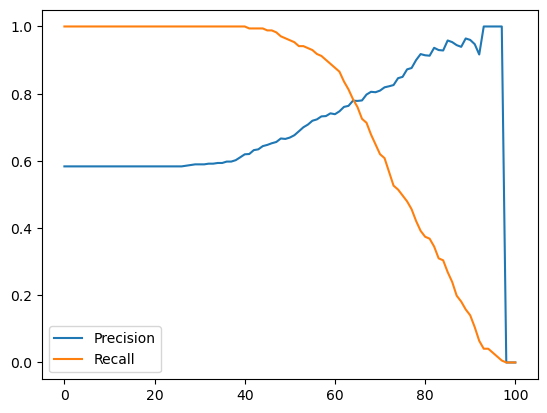

In [63]:
# Q3 Precision and Recall

thresholds = np.linspace(0, 1, 101)
pre = []
rec = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    pre.append(p)
    r = tp / (tp + fn) if (tp + fn) > 0 else 0
    rec.append(r)

plt.plot(pre, label = "Precision")
plt.plot(rec, label = "Recall")
plt.legend()

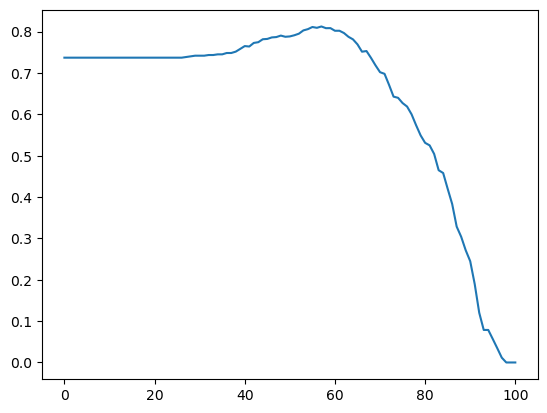

In [65]:
# Q4 - F1 score

thresholds = np.linspace(0, 1, 101)

F1 = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0

    f1 = 2 * ((p * r) / (p + r)) if (p + r) > 0 else 0
    F1.append(f1)

plt.plot(F1)

Maximum F1 score: 0.812
At threshold: 0.570


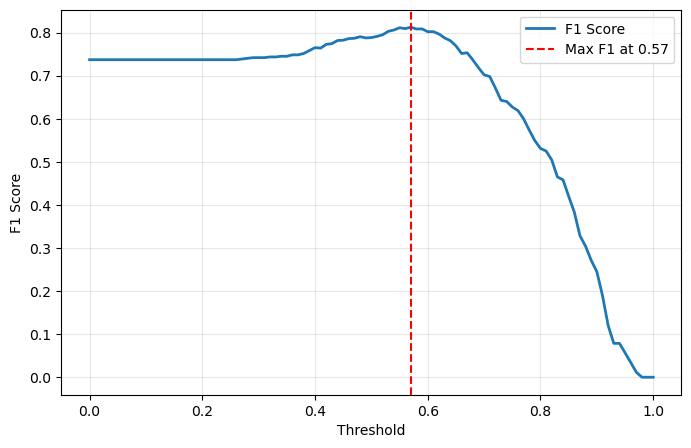

In [ ]:
# better plot by Claude

# Convert to numpy array
F1 = np.array(F1)

# Find the threshold with maximum F1
max_f1_idx = np.argmax(F1)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = F1[max_f1_idx]

print(f"Maximum F1 score: {max_f1_value:.3f}")
print(f"At threshold: {max_f1_threshold:.3f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, F1, linewidth=2, label='F1 Score')
plt.axvline(max_f1_threshold, color='red', linestyle='--', 
            label=f'Max F1 at {max_f1_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [66]:
# Q5 - 5-Fold CV

def train(df_train, y_train,):
    dicts = df_train[categorical + numerical].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df_val, dv, model):
    dicts = df_val[categorical + numerical].to_dict(orient="records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [72]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    scores.append(roc_auc_score(y_val, y_pred))
    
print(np.mean(scores), np.std(scores))

0.8221089148573075 0.03580711942905165


In [74]:
# Q6 - Hyperparameter Tuning
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model


for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        scores.append(roc_auc_score(y_val, y_pred))
    
    print("C=%s %.3f +-%.3f" % (C, np.mean(scores), np.std(scores)))


C=1e-06 0.560 +-0.024
C=0.001 0.867 +-0.029
C=1 0.822 +-0.036
